# Feature Quality Selection using Feature-Engine
<span style="color:skyblue"> Thanks to João Pinto Moura and Tingting Qiao (ING RPAA) for material.</span>


Goal of the notebook: Show how to use the functionalities of feature-engine to remove features based on `quality criteria`:
- Correlation.
- Uniqueness.
- `Feature stability`
- Relationship with the target.
- ...


### Feature selection is an important part of the modelling pipeline

- Feature generation is important because it is the basis of modelling; it provides the required `information` to you model.
- Features are often `generated in an automated way` this results in:
  - `Many features`.
  - Feature containing little to `no information` on the target.
  - `Correlated` and duplicated features.
  - `Meaningless` features (Statistically of from a Business point of view) 

### Never blindly use all features 

When using Tree based approaches, a large amount of features can be used but:

- You want to work with only the `most relevant features` and disregard the ones that have little impact.
  - It can be hard to find stable estimates of the importance of [multi collinear features](https://en.wikipedia.org/wiki/Multicollinearity);
  - Each feature must be monitored in production, which is time consuming.
- You want to remove feature with `poor quality`.
  - Little variance.
  - Drifted features.
  - ...

### Use a quality selection pipeline

There are functionalities for feature selection based on quality criteria which can help you reduce the number of features to a smaller set of more interesting ones.

- We will use well known packages, like `scikit-learn` and `feature-engine` to provide some basic examples.
- We focus on `binary supervised classification` settings, even though most techniques can also be applied in other ones.
- We ignore dimensionality reduction methods, since they usually make features hard to understand and therefore decrease model interpretation.

# Set-up

### Import packages

In [1]:
import pandas as pd
import math

from datetime import date
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

### Generate a toy dataset

We start by generating a dataset that has a lot of the most commonly encountered issues:

- 8 informative features (`n_informative=8`)
- 2 features are duplicates of others (`n_repeated=2`)
- 2 features have a high correlation with others (`n_redundant=2`)
- 2 features have no relation with the target (`n_features - (n_informative + n_redundant + n_repeated)`)
- 1 constant feature (`fconst`)

We will introduce you to a few selectors that are able to automatically find and drop the less interesting features.

In [2]:
def make_df(n_samples, n_features, n_informative, n_redundant, n_repeated):
    # Define number of features in the dataset
    feature_names = [f'f{idx}' for idx in range(1, n_features+1)]

    # Prepare sample dataset
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, 
                               n_redundant=n_redundant, n_repeated=n_repeated, n_clusters_per_class=1, random_state=42)

    X = pd.DataFrame(X, columns=feature_names)
    # Add a constant feature
    X = X.assign(fconst='21')

    # Create a date (for example data collection time)
    X['time'] = [date(year, 1, 1) for year in range(1000, 1000+n_samples)]
    # and a drifted feature
    def drift(i,shift=500, scaler=100, multiplier=5):
        scaled = (i - shift) /scaler
        lr = math.exp(scaled) / (1 + math.exp(scaled))
        return lr * multiplier

    X['fdrifted'] =  [drift(i) for i in range(n_samples)] + X['f1']
    
    # Let's shuffle the dataframe and reset the index to remove the correlation
    # between the index and the time variables.
    X = X.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split the dataset into train and test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = make_df(n_samples=1000, n_features=14, n_informative=8, n_redundant=2, n_repeated=2)

In [60]:
X_train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,fconst,time,fdrifted
541,0.315208,0.165973,-0.455265,1.230478,-2.355761,0.532805,0.165973,-1.459281,-0.424927,-0.481113,0.532805,1.181398,-0.466431,0.522459,21,1271-01-01,0.774981
440,3.182522,2.468385,-3.860928,1.912530,0.325369,0.646273,2.468385,0.722990,-0.103920,2.269616,0.646273,-2.103202,0.627392,-1.660623,21,1223-01-01,3.477358
482,0.989527,2.398190,-0.542532,1.868272,1.984632,1.989290,2.398190,-1.285305,-0.633444,2.369770,1.989290,-0.191011,-0.485791,-1.693060,21,1011-01-01,1.026853
422,-0.624577,1.550901,-2.709133,-1.572099,-0.799271,-0.586931,1.550901,-1.209859,-0.512580,-0.391629,-0.586931,-1.544796,-0.359699,-0.317450,21,1483-01-01,1.663433
778,-2.353799,-0.968235,3.755823,-1.040770,-1.870091,-3.372080,-0.968235,-0.929689,0.096736,1.034186,-3.372080,2.373450,0.074004,3.116186,21,1258-01-01,-1.945498


### Install `feature-engine`

`scikit-learn` has [some feature selectors](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection), but the choice is relatively poor.

One great library is [feature-engine](https://feature-engine.readthedocs.io/en/1.1.x/selection/index.html).
This includes a large and useful variety of feature selectors which we frequently use in RPAA projects.
It is compatible with the `scikit-learn` pipeline syntax, so it is very easy to integrate into most projects.

Let's install it:

In [61]:
#! pip install feature_engine
#! pip install probatus

# Constant or low variance features

Constant features, or features with very low variance, generally have little information that models can learn from.
As such we can safely drop them from the modelling dataset.


Here we use `feature_engine.selection.DropConstantFeatures` to find and drop the `fconst` constant feature which we added to the dataset. 
This class drops all features which have the same value in more than a fraction `tol` of rows of the total.

This class is roughly equivalent to `sklearn.feature_selection.VarianceThreshold`.

In [62]:
from feature_engine.selection import DropConstantFeatures

In [63]:
# set up the transformer
transformer_drop_constant = DropConstantFeatures(tol=0.99, missing_values='ignore')

# fit the transformer
transformer_drop_constant.fit(X_train)
print(f"Features to drop: {transformer_drop_constant.features_to_drop_}")

# transform the data
X_train_no_constant = transformer_drop_constant.transform(X_train)
print(f"Remaining features: {X_train_no_constant.columns}")

Features to drop: ['fconst']
Remaining features: Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'time', 'fdrifted'],
      dtype='object')


# Correlated features

*Highly* correlated features contains the `same information`. It could be beneficial to `pick up one` of the correlated feature and remove the other ones. Selection can be done:
- Arbitrarily.
- Based on features statistics (number of missing values, variance, correlation with target, ...).
- Prediction power.
- ...


We use `feature_engine.selection.DropCorrelatedFeatures` to drop the `n_redundant=2` correlated features that are in the dataset. This class finds features with a correlation factor higher than `threshold` and keeps only one of those features.
It accepts numerical features only.


In [64]:
from feature_engine.selection import DropCorrelatedFeatures

In [65]:
# set up the transformer
transformer_drop_correlated = DropCorrelatedFeatures(threshold=0.8)

# fit the transformer
transformer_drop_correlated.fit(X_train_no_constant)
print(f"Features to drop: {transformer_drop_correlated.features_to_drop_}")

# transform the data
X_train_no_correlated = transformer_drop_correlated.transform(X_train_no_constant)
print(f"Remaining features: {X_train_no_correlated.columns}")

Features to drop: {'f7', 'f11', 'f12'}
Remaining features: Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f10', 'f13', 'f14',
       'time', 'fdrifted'],
      dtype='object')


> Tip: when multiple features are correlated with each other, which ones should you drop?
[`SmartCorrelatedSelection`](https://feature-engine.readthedocs.io/en/1.1.x/selection/SmartCorrelatedSelection.html) automatically finds clusters of correlated features and lets you keep only the:
- Feature with least missing values
- Feature with most unique values
- Feature with highest variance
- Best performing feature according to an estimator defined by you

# Features with a drift

Once deployed in production, the `performance of Machine Learning models usually erode with time` because the world is changing. 
- Macro-economic changes (inflation, recessions, crisis, ...).
- Customer behavior changes (home-banking penetration, ).
- Processes changes (new products, ...).

Changes in the data distribution in production, could lead to biased predictions. Data drift is a major reason model accuracy decreases over time.


![shift](../pictures/Shift.png)
</p>
<p align = "left">
<span style="color:skyblue">Figure 1 - Example of drift in data distribution</span>
</p>


## PSI: A simple way to assess population shift

PSI stands for Population Stability Index. It is a single number that summarizes how much two distribution differ. It is computed in the following way:
- Define the `two distributions` to compare (for example train and test).
- Define buckets (bins) to `discretize` the reference population (usually train).
- Compute the `percentage` of observation falling in each bucket for train.
- Compute the percentage of observation falling in each bucket for test.
- Compute the `PSI` using the following formula

![PSI](../pictures/PSI.png)

</p>
<p align = "left">
<span style="color:skyblue">Equation 1 - Formula to compute the PSI value. A threshold of 0.25 is standard to design a significant change in population.</span>
</p>


**More info: [PSI is related to the Kullback Liebler divergence](https://scholarworks.wmich.edu/cgi/viewcontent.cgi?article=4249&context=dissertations)**

## What are the use cases?

- Data is collected over a `long period` of time.
- Data is collected over `different groups` (common model for mortgages, personal loans, credit card, ...)

![internet banking Belgium](../pictures/IB_share.png)
</p>
<p align = "left">
<span style="color:skyblue">Figure 2 - Penetration of internet banking in Belgium (https://www.statista.com) </span>
</p>

## Be careful

- High PSI value may come from "natural" behavior like seasonality or Covid spike.
- PSI value is depending on the bucketing approach.
- PSI is a univariate measure.


### How to deal with high PSI features?

- A feature with high PSI value is not bad by definition.
- It is important to understand the nature of the high PSI.
- Some feature may have lower PSI values once transformed: Income => Income / Average(Income)

## Tooling

- The [Probatus](https://ing-bank.github.io/probatus/tutorials/nb_distribution_statistics.html) package contains several functionalities to estimate population shift.
- Feature engine has a transformer to remove features with high PSI (developed by RPAA'er)

### DropHighPSIFeatures from Feature Engine

[DropHighPSIFeatures](https://feature-engine.readthedocs.io/en/1.2.x/api_doc/selection/DropHighPSIFeatures.html) signature is mostly driven by:
- How to split the dataframe in order to define the distribution to compare.
- How to compute the PSI (buckets and threshold)

- https://trainindata.medium.com/how-to-select-features-based-on-the-population-stability-index-58a1f0283583
- https://github.com/feature-engine/feature-engine-examples/blob/main/selection/Drop-High-PSI-Features.ipynb
- https://github.com/feature-engine/feature_engine/blob/main/docs/user_guide/selection/DropHighPSIFeatures.rst

Remember, we introduced a `drifted` feature in the dataset. Let's first look at the behavior of the feature over time.

In [66]:
import matplotlib

<AxesSubplot:xlabel='time'>

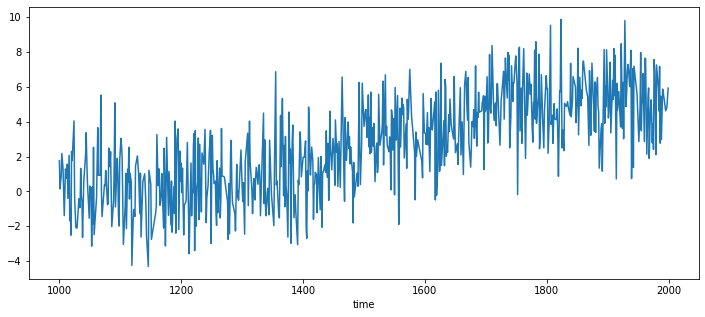

In [67]:
X_train.groupby('time')['fdrifted'].mean().plot(figsize=(12, 5))

Looking at the `cumulative density function` before and after 1500 clearly shows a difference in distribution.

In [68]:
import seaborn as sns
X_train['above_cut_off'] = X_train.time > date(1500, 1, 1)


<AxesSubplot:xlabel='fdrifted', ylabel='Proportion'>

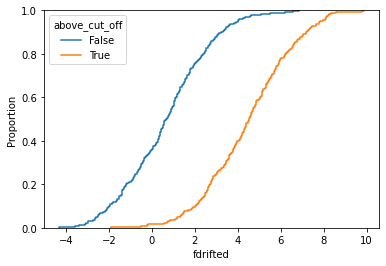

In [69]:
sns.ecdfplot(data=X_train, x='fdrifted', hue='above_cut_off')

In [70]:
from feature_engine.selection import DropHighPSIFeatures

In [71]:
# set up the transformer
transformer_psi = DropHighPSIFeatures(split_col='time', cut_off=date(1789, 7, 14))

# fit the transformer
transformer_psi.fit(X_train_no_correlated, y=y_train)
print(f"Features to drop: {transformer_psi.features_to_drop_}")

# transform the data
X_train_no_corr_target = transformer_psi.transform(X_train_no_correlated)
print(f"Remaining features: {X_train_no_corr_target.columns}")

Features to drop: ['fdrifted']
Remaining features: Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f10', 'f13', 'f14',
       'time'],
      dtype='object')


In [72]:
transformer_psi.psi_values_

{'f1': 0.040028163520957526,
 'f2': 0.04903601046867709,
 'f3': 0.1773192969111151,
 'f4': 0.07821614775674682,
 'f5': 0.0674080166889609,
 'f6': 0.08253123784159076,
 'f8': 0.04104467713747409,
 'f9': 0.10625761905421968,
 'f10': 0.08407756283310111,
 'f13': 0.05284592071083042,
 'f14': 0.1035049717122653,
 'fdrifted': 2.9760117997649234}

# Pipeline syntax

`Feature-engine` is compatible with the `scikit-learn` pipeline syntax. This means they can easily be combined with Sklearn pipeline functionalities.
Let's illustrate how this is working.

In [76]:
# Re-creating the dataset
X_train, X_test, y_train, y_test = make_df(n_samples=1000, n_features=14, n_informative=8, n_redundant=2, n_repeated=2)

In [77]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures

# Set up a pipeline
fs_pipeline = Pipeline(
    [
        ("drop_constant", DropConstantFeatures(tol=0.99, missing_values='ignore')), 
        ("drop_correlated", DropCorrelatedFeatures(threshold=0.85)), 
        ("drop_psi", DropHighPSIFeatures(split_col='time', cut_off=date(1789, 7, 14))),
        ("drop_time", DropFeatures(['time'])),
    ]
)

# Fit the pipeline
fs_pipeline.fit(X_train, y_train)

# Transform the data
X_train_transformed = fs_pipeline.transform(X_train)
print(f"Remaining features: {X_train_transformed.columns}")

Remaining features: Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f10', 'f13', 'f14'], dtype='object')


> Be carefull the order of the selector in the pipeline does matter. Try to put the univariate selectors first.

> Tip: in most `feature-engine` selectors, you can define to which variables the selector should be applied to, using the argument `variables`. You can use this to ignore information columns which should not be used as features, or to apply different pipelines to categorical and numerical columns, for example.

# Please try this at home!

- After looking at the data, you realize that some of the features (f2, f3 and f14) are not fit for modelling. Add the `DropFeature` functionality to the pipeline and re-run it. 
- Check the functionality removed the correct features.
- Try the SmartCorrelatedSelection
